In [53]:
#for offline run
%cd ../input/yolov8
!pip install -e
%pip install ultralytics

[Errno 2] No such file or directory: '../input/yolov8'
/

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

-e option requires 1 argument
Note: you may need to restart the kernel to use updated packages.


In [54]:
import torch
print(torch.__version__)

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.123 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4813.9/8062.4 GB disk)


In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import cv2
import torchvision
import seaborn as sns

from glob import glob
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from shutil import copyfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [56]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


# Hyperparameters

In [57]:
config ={
    'num_epochs' : 2
    ,'num_classes' : 34 #yolo는 그대로
    ,'batch_size' : 32
    ,'kfold' : 2
    ,'train_path' : '/kaggle/input/hello-marine-corps/train'
    ,'valid_path' : '/kaggle/input/hello-marine-corps/valid'
    ,'mode' : 'yolov8n'
    ,'optimizer' : 'AdamW' #ADAM, ADAMW, SGD
    ,'lr' : 0.0005
    ,'iou_thr' : 0.5
    ,'Score_threshold' : 0.5
    ,'glob_testimgs' : '/kaggle/input/hello-marine-corps/test/*.png'
    #원래 배치 2에 d5
    ,'seed' : 42
    
    #lr_scheduler
    ,'time' : 15 # 에폭을 크게 할 수록 늘릴것. cosin의 경우 맥스 값 이하로 랜덤하게 적용
    ,'T_mul' : 2
    , 'lr_scheduler' : 'CosineAnnealingWarmRestarts'        #'CosineAnnealing' #'StepLR'
#    예를 들어, 트레인 데이터셋 크기가 50,000이고 배치 크기가 128이라면 초기 주기는 50,000 / 128 = 391입니다.
    
    ,'img_resize' : 128 #256,512,640,1024
# TRAIN_PATH = '/kaggle/input/hello-marine-corps/train/'
# TEST_PATH = '/kaggle/input/hello-marine-corps/test/'
# IMG_SIZE_W = 1920
# IMG_SIZE_H = 1040
# IMG_SIZE = 640
# BATCH_SIZE = 16
# EPOCHS = 2
    
# TRAIN_PATH_ = '/kaggle/working/images/train'
# TRAIN_LABEL_PATH = '/kaggle/working/labels/train'
# #device = torch.device('cuda' if cuda.is_available() else 'cpu')
}

# Prepare Dataset

In [58]:
df = pd.DataFrame(columns=['img_path', 'txt_path', 'annot'])
bbox_df = pd.DataFrame(columns=['img_path', 'txt_path','source', 'xmin','ymin','xmax','ymax'])

txt_path_list = glob('/kaggle/input/hello-marine-corps/train/*.txt')
img_path_list = glob('/kaggle/input/hello-marine-corps/train/*.png')
test_path_list = glob('/kaggle/input/hello-marine-corps/train/*.png')

# 파일 리스트 정렬
txt_path_list.sort()
img_path_list.sort()

data = []
bbox_data = []
for i in range(len(txt_path_list)):
    filename = txt_path_list[i].split('/')[-1]
    
    with open(txt_path_list[i], 'r') as f:
        lines = f.readlines()
        array = []
        for line in lines:
            source =int(float(line.strip().split()[0]))
            xmin = float(line.strip().split()[1])
            ymin = float(line.strip().split()[2])
            xmax = float(line.strip().split()[3])
            ymax = float(line.strip().split()[8])
            bbox_data.append({
                                'img_path': img_path_list[i], 
                                'txt_path': txt_path_list[i], 
                                'source': source,
                                'xmin': xmin,
                                'ymin': ymin,
                                'xmax': xmax,
                                'ymax': ymax})
            array.append([source, xmin, ymin, xmax, ymax])
        data.append({
                     'img_path': img_path_list[i],
                     'txt_path': txt_path_list[i],
                     'annot' : array
                                  })
        
        
df = pd.concat([df, pd.DataFrame(data)])
bbox_df = pd.concat([bbox_df, pd.DataFrame(bbox_data)])

print(df.head())
print(len(df))
print(bbox_df.head())
print(len(bbox_df))

                                            img_path  \
0  /kaggle/input/hello-marine-corps/train/syn_000...   
1  /kaggle/input/hello-marine-corps/train/syn_000...   
2  /kaggle/input/hello-marine-corps/train/syn_000...   
3  /kaggle/input/hello-marine-corps/train/syn_000...   
4  /kaggle/input/hello-marine-corps/train/syn_000...   

                                            txt_path  \
0  /kaggle/input/hello-marine-corps/train/syn_000...   
1  /kaggle/input/hello-marine-corps/train/syn_000...   
2  /kaggle/input/hello-marine-corps/train/syn_000...   
3  /kaggle/input/hello-marine-corps/train/syn_000...   
4  /kaggle/input/hello-marine-corps/train/syn_000...   

                                               annot  
0  [[9, 1037.0, 209.0, 1312.0, 448.0], [25, 804.0...  
1  [[16, 1000.0, 98.0, 1295.0, 405.0], [14, 678.0...  
2  [[4, 1108.0, 313.0, 1391.0, 616.0], [2, 705.0,...  
3  [[15, 1118.0, 439.0, 1435.0, 731.0], [13, 614....  
4  [[11, 1002.0, 124.0, 1305.0, 472.0], [13, 691...

In [59]:
unq_values = df["img_path"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

Total Records:  6481
Unique Images:  6481


In [60]:
### Data Sources

sources = bbox_df["source"].unique()
print("Total Sources: ",len(sources))
print("\n> Sources <\n",sources)

Total Sources:  34

> Sources <
 [9 25 12 16 14 31 4 2 15 13 11 3 20 1 5 32 6 18 17 24 27 33 19 23 26 10 29 22 7 21 8 30 0 28]


<Axes: title={'center': 'Source Distribution'}, xlabel='source', ylabel='count'>

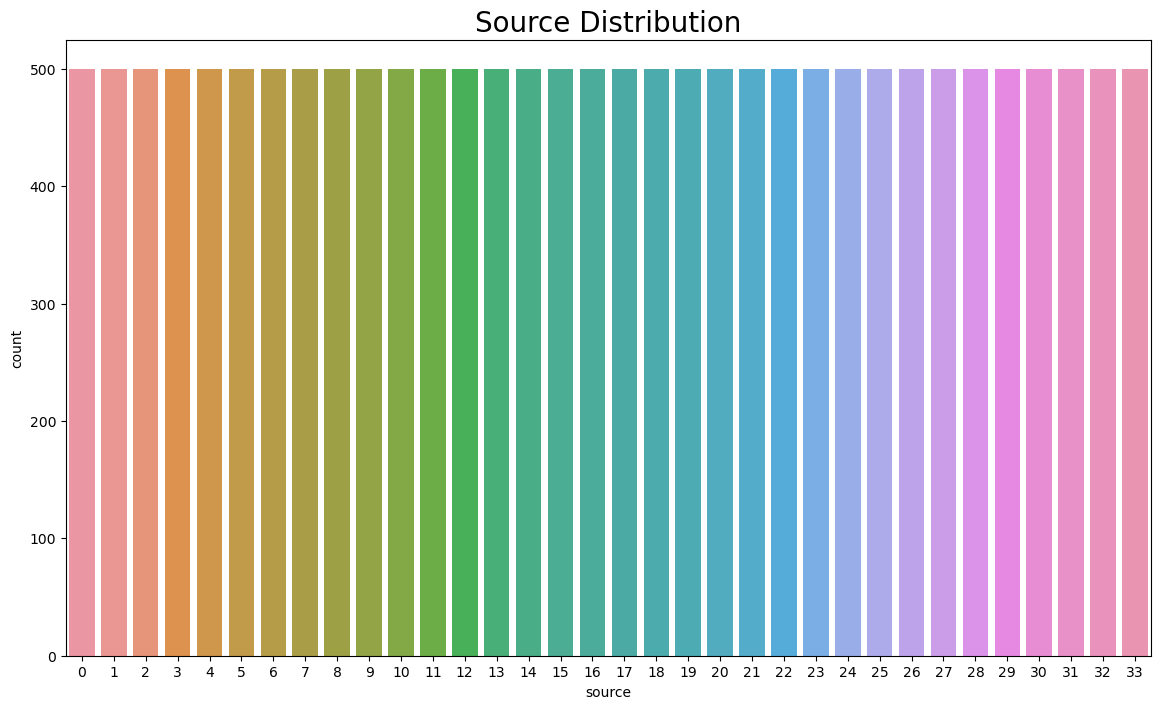

In [61]:
### Visualizing Source Distribution
plt.figure(figsize=(14,8))
plt.title('Source Distribution', fontsize= 20)
sns.countplot(x = "source", data = bbox_df)

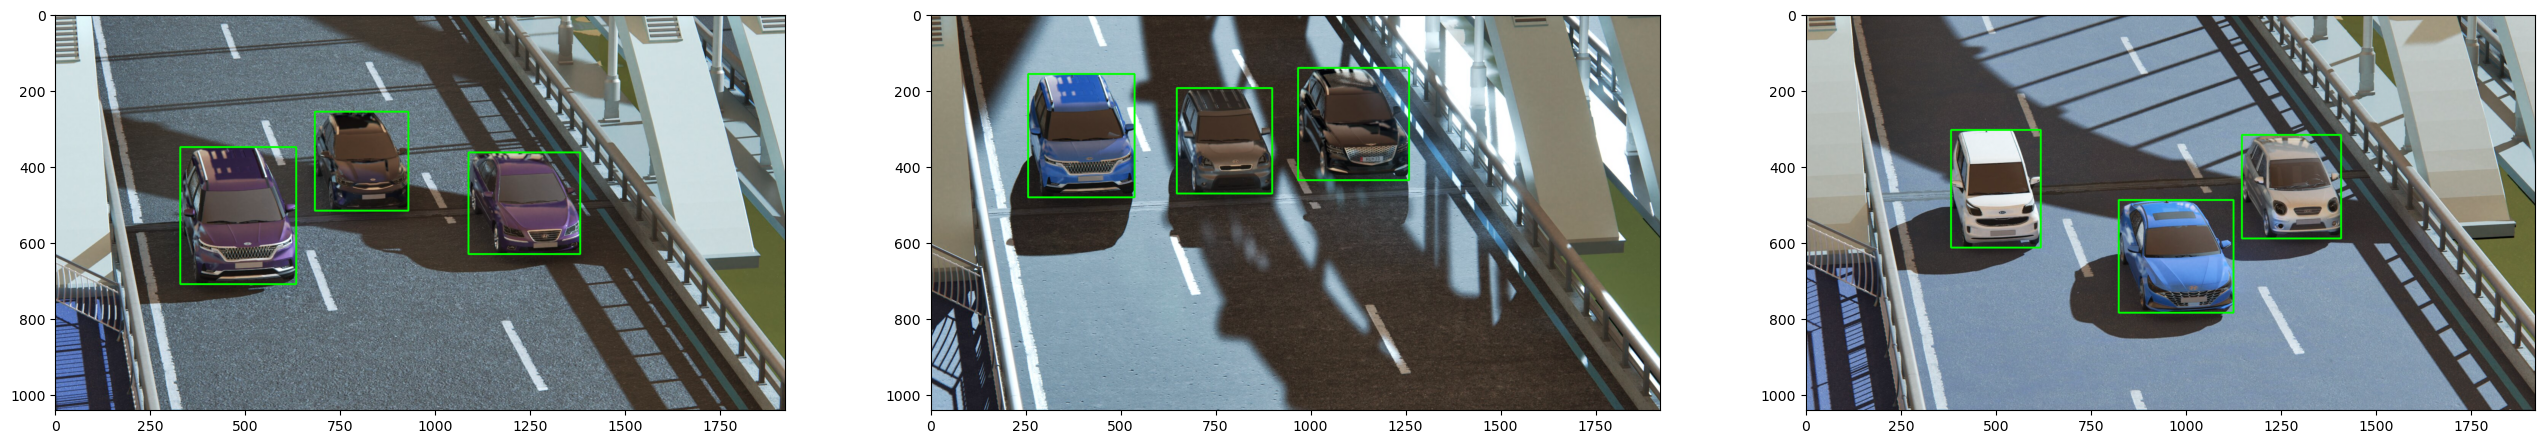

img_path    /kaggle/input/hello-marine-corps/train/syn_000...
txt_path    /kaggle/input/hello-marine-corps/train/syn_000...
source                                                      0
xmin                                                    243.0
ymin                                                     60.0
xmax                                                    481.0
ymax                                                    365.0
dtype: object

In [62]:
# Inspecting images = 이미지 검사
fig = plt.figure(figsize=(32,32))
fig

#plot 1*3
columns=3
rows=1

#그리고 df.values를 사용하면 DataFrame의 값에 해당하는 부분만 2차원 array의 형태로 얻을 수 있습니다.
for i in range(1, columns*rows + 1):  
        #이미지를 임의로 설정    
    idx = np.random.randint(0, len(bbox_df['img_path'].unique()))
    image_path = bbox_df.iloc[idx]['img_path']
    new_df = bbox_df[bbox_df['img_path']==image_path]
    new_df = new_df.reset_index(drop=True)
    img = cv2.imread(new_df['img_path'][0])
    bboxes=[]
    for j in range(len(new_df)):
        bboxes.append([new_df['xmin'][j],new_df['ymin'][j],new_df['xmax'][j],new_df['ymax'][j]])

    for bbox in bboxes:  
        bbox = list(map(int, bbox))
        cv2.rectangle(img,
                      (bbox[0], bbox[1]), (bbox[2],bbox[3]),
                      color=(0, 255, 0), thickness=3)

    fig.add_subplot(rows, columns, i)

    plt.imshow(img)
plt.show() 
bbox_df.max()
bbox_df.min()

# Transform to COCO Bbox

In [63]:
new_bbox_df = pd.DataFrame(columns = ['img_path', 'txt_path', 'source', 'x_c', 'y_c', 'w', 'h'])
for i in range(len(bbox_df)):
    result = [] # x_c, y_c,w,h 
    result.append(bbox_df.iloc[i]['img_path'])
    result.append(bbox_df.iloc[i]['txt_path'])
    result.append(bbox_df.iloc[i]['source'])
    xmin = bbox_df.iloc[i]['xmin']
    xmax = bbox_df.iloc[i]['xmax']
    ymin = bbox_df.iloc[i]['ymin']
    ymax = bbox_df.iloc[i]['ymax']
    
    x_c = (xmin+xmax)/2
    y_c = (ymin+ymax)/2
    w = xmax - xmin
    h = ymax - ymin
    result.append(x_c) #x_c
    result.append(y_c) #y_c
    result.append(w) #w
    result.append(h) #h
    new_bbox_df.loc[len(new_bbox_df)]=result

new_bbox_df.head()


,img_path,txt_path,source,x_c,y_c,w,h
0,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,9,1174.5,328.5,275.0,239.0
1,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,25,965.5,604.0,323.0,358.0
2,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,12,456.5,380.5,253.0,261.0
3,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,16,1147.5,251.5,295.0,307.0
4,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,14,802.0,298.0,248.0,246.0


# CoCo Dataframe index : img

In [64]:
new_df = pd.DataFrame(columns=['img_path', 'txt_path', 'annot'])

new_data=[]
for i in range(len(df)):
    result = []
    result.append(df.iloc[i]['img_path'])
    result.append(df.iloc[i]['txt_path'])
    annots = df.iloc[i]['annot']
    l = []
    for j in range(len(annots)):
        xmin = annots[j][1]
        ymin = annots[j][2]
        xmax = annots[j][3]
        ymax = annots[j][4]
        l.append([annots[j][0],(xmin+xmax)/2,(ymin+ymax)/2, xmax-xmin, ymax-ymin])
    result.append(l)
    new_df.loc[len(new_df)]=result

new_df.head()     

,img_path,txt_path,annot
0,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,"[[9, 1174.5, 328.5, 275.0, 239.0], [25, 965.5,..."
1,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,"[[16, 1147.5, 251.5, 295.0, 307.0], [14, 802.0..."
2,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,"[[4, 1249.5, 464.5, 283.0, 303.0], [2, 823.0, ..."
3,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,"[[15, 1276.5, 585.0, 317.0, 292.0], [13, 739.0..."
4,/kaggle/input/hello-marine-corps/train/syn_000...,/kaggle/input/hello-marine-corps/train/syn_000...,"[[11, 1153.5, 298.0, 303.0, 348.0], [13, 825.5..."


In [65]:
new_df.iloc[0]['annot']

[[9, 1174.5, 328.5, 275.0, 239.0],
 [25, 965.5, 604.0, 323.0, 358.0],
 [12, 456.5, 380.5, 253.0, 261.0]]

# Create .YAML file

In [66]:
# %%writefile dataset.yaml
# path: f'/kaggle/working/'
# train: f'images/train/'
# val: f'images/valid/'
# test: f'images/test/'

# nc: 34
# names:
#     - 0
#     - 1
#     - 2
#     - 3
#     - 4
#     - 5
#     - 6
#     - 7
#     - 8
#     - 9
#     - 10
#     - 11
#     - 12
#     - 13
#     - 14
#     - 15
#     - 16
#     - 17
#     - 18
#     - 19
#     - 20
#     - 21
#     - 22
#     - 23
#     - 24
#     - 25
#     - 26
#     - 27
#     - 28
#     - 29
#     - 30
#     - 31
#     - 32
#     - 33


In [67]:
# %cat dataset.yaml

In [68]:
def writefile_dataset_yaml(fold):
    with open('/kaggle/working/fold_'+str(fold+1)+'/dataset_'+str(fold+1)+'.yaml', 'a') as file: # 여기에 저장
        file.write("path: /kaggle/working/fold_"+str(fold+1)+"\n")  
        file.write("train: images/train\n")
        file.write("val: images/valid\n")
        file.write("test: images/test\n\n")
        
/kaggle/working/fold_'+str(fold+1)+'/images/valid/
        
        file.write(f"nc: {config['num_classes']}\n")
        file.write("names:\n")
        for i in range(config['num_classes']):
            file.write(f"  - {i}\n")

In [69]:
# %%writefile dataset.yaml

# path: /kaggle/working
# train: images/train
# val: images/valid
# test: images/test

# # Classes
# names:
#     0: none
#     1: opacity
        
# lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
# lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
# momentum: 0.937  # SGD momentum/Adam beta1
# weight_decay: 0.0005  # optimizer weight decay 5e-4
# warmup_epochs: 3.0  # warmup epochs (fractions ok)
# warmup_momentum: 0.8  # warmup initial momentum
# warmup_bias_lr: 0.1  # warmup initial bias lr
# box: 0.5  # box loss gain
# cls: 0.5  # cls loss gain
# cls_pw: 1.0  # cls BCELoss positive_weight
# obj: 1.0  # obj loss gain (scale with pixels)
# obj_pw: 1.0  # obj BCELoss positive_weight
# iou_t: 0.20  # IoU training threshold
# anchor_t: 4.0  # anchor-multiple threshold
# # anchors: 3  # anchors per output layer (0 to ignore)
# fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
# hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
# hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
# hsv_v: 0.4  # image HSV-Value augmentation (fraction)
# degrees: 10.0  # image rotation (+/- deg)
# translate: 0.10  # image translation (+/- fraction)
# scale: 0.80  # image scale (+/- gain)
# shear: 10.0  # image shear (+/- deg)
# perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
# flipud: 0.5  # image flip up-down (probability)
# fliplr: 0.5  # image flip left-right (probability)
# mosaic: 0.75  # image mosaic (probability)
# mixup: 0.2 # image mixup (probability)
# copy_paste: 0.0  # segment copy-paste (probability)

In [70]:
def delete_directory(directory):
    # 디렉토리 내부의 모든 파일 삭제
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            delete_directory(file_path)  # 재귀적으로 하위 디렉토리의 파일 삭제

    # 빈 디렉토리 삭제
    os.rmdir(directory)

# Image,Txt Save to Kfolder, Train!

In [71]:
# os.makedirs(f'/kaggle/working/fold_{fold+1}/images/test', exist_ok=True)
# os.makedirs(f'/kaggle/working/fold_{fold+1}/labels/test', exist_ok=True)
    

In [ ]:
from sklearn.model_selection import KFold
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# K-fold cross-validation 객체 생성
kfold = KFold(n_splits=config['kfold'], shuffle=True, random_state = config['seed'])
for fold, (train_indices, val_indices) in enumerate(kfold.split(new_df)):
    print(f"Fold: {fold + 1}")

    os.makedirs(f'/kaggle/working/fold_{fold+1}', exist_ok=True)
    os.makedirs(f'/kaggle/working/fold_{fold+1}/images', exist_ok=True)
    os.makedirs(f'/kaggle/working/fold_{fold+1}/labels', exist_ok=True)
    os.makedirs(f'/kaggle/working/fold_{fold+1}/images/train', exist_ok=True)
    os.makedirs(f'/kaggle/working/fold_{fold+1}/images/valid', exist_ok=True)
    os.makedirs(f'/kaggle/working/fold_{fold+1}/labels/train', exist_ok=True)
    os.makedirs(f'/kaggle/working/fold_{fold+1}/labels/valid', exist_ok=True)
    %cd ../../../../

    #writefile_dataset_yaml(fold)
    # 훈련 세트, 검증 세트 분할
    train_df = new_df.iloc[train_indices].reset_index(drop=True)
    valid_df = new_df.iloc[val_indices].reset_index(drop=True)
    train_img_paths = train_df['img_path'].unique()
    
    # save train
    for i, img_path in tqdm(enumerate(train_img_paths)): # 이미지별 txt 접근
        #Train images
        img = cv2.imread(img_path)
        width = img.shape[1]
        height = img.shape[0]
        img_id = img_path.split('/')[-1].split('.')[0]
        copyfile(img_path, '/kaggle/working/fold_'+str(fold+1)+'/images/train/'+img_id+'.png') # 왼쪽을 오른쪽으로
        
        #Train txts
        file_name = '/kaggle/working/fold_'+str(fold+1)+'/labels/train/'+img_id+'.txt'
        
        rows = train_df.loc[train_df['img_path']==img_path]
        l=[]
        for annot in rows.iloc[0]['annot']:
            yolo_box=[int(annot[0])
                      ,annot[1]/width
                      ,annot[2]/height
                      ,annot[3]/width
                      ,annot[4]/height] # x_center y_center width height
            yolo_box = str(yolo_box).replace("[", "").replace("]","").replace(",","")
#         l = str(l).replace("[", "").replace("]","").replace(",","")
            with open(file_name, 'a') as f:
                f.write(yolo_box)
                f.write('\n')
                f.close()
    
    print(f'save_fold{fold+1}_train_file_end!')
    
    valid_img_paths = valid_df['img_path'].unique()
    # save valid
    for i, img_path in tqdm(enumerate(valid_img_paths)): 
        #Valid images
        img = cv2.imread(img_path)
        width = img.shape[1]
        height = img.shape[0]
        img_id = img_path.split('/')[-1].split('.')[0]
        route1 = '/kaggle/working/fold_'+str(fold+1)+'/images/valid/'+img_id+'.png'
        copyfile(img_path,route1) # 왼쪽을 오른쪽으로
        
        #Valid txts
        file_name = '/kaggle/working/fold_'+str(fold+1)+'/labels/valid/'+img_id+'.txt'
        
        rows = valid_df.loc[valid_df['img_path']==img_path]            
        l=[]
        for annot in rows.iloc[0]['annot']:
            yolo_box=[int(annot[0])
                      ,annot[1]/width
                      ,annot[2]/height
                      ,annot[3]/width
                      ,annot[4]/height] # x_center y_center width height
            yolo_box = str(yolo_box).replace("[", "").replace("]","").replace(",","")
            with open(file_name, 'a') as f:
                f.write(yolo_box)
                f.write('\n')
                f.close()
    
    print(f'save_fold{fold+1}_valid_file_end!')
    
    
    
    ###### Train
    model = YOLO(f"{config['mode']}.yaml")  # build a new model from scratch ,initiate
    model = YOLO("../../input/roi-mammography416-yolov8/ROI Mammography 416/yolov8n.pt")  # load a pretrained model
#     results = model.train(
# #         data=f"/kaggle/working/dataset.yaml",
#         data = '/kaggle/working/fold_'+str(fold+1)+'/dataset_'+str(fold+1)+'.yaml',
#         imgsz=(config['img_resize'],config['img_resize']),
#         epochs=config['num_epochs'],
#         batch=config['batch_size'],
#         patience=10,
#         workers=4,
#         device=0,
#         exist_ok=True,    
#         project=f"{config['mode']}_fold_{fold+1}",
#         name="train",
#         seed=config['seed'],
#         optimizer=config['optimizer'],
#         lr0=config['lr'],
#         )
    model.train(data='/kaggle/working/fold_'+str(fold+1)+'/dataset_'+str(fold+1)+'.yaml', 
                epochs=config['num_epochs'], 
                imgsz=config['img_resize'], 
                batch=config['batch_size'], 
                save_period=1, 
                amp=True)
 
    print('next fold')

Fold: 1
/


3240it [05:40,  9.52it/s]


save_fold1_train_file_end!


3241it [05:52,  9.19it/s]

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.

save_fold1_valid_file_end!


YOLOv8n summary: 225 layers, 3157200 parameters, 3157184 gradients

Ultralytics YOLOv8.0.123 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=../../input/roi-mammography416-yolov8/ROI Mammography 416/yolov8n.pt, data=/kaggle/working/fold_1/dataset_1.yaml, epochs=2, patience=50, batch=32, imgsz=128, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=

In [ ]:
'''src = '/kaggle/input/hello-marine-corps/test'
trg = '/kaggle/working/images/test'

files=os.listdir(src)

for fname in files:
    shutil.copy2(os.path.join(src,fname), trg)
    '''

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf
device_lib.list_local_devices() # tensor flow에서 gpu를 사용하는지 확인하는 법
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

## 모델 학습에 GPU를 사용하는지 확인

In [ ]:
import time
from sklearn.datasets import make_regression
from xgboost import XGBRegressor

def model_test(model_name, model):
    x, y = make_regression(n_samples=100000, n_features=100)
    
    start_time = time.time()
    model.fit(x, y)
    end_time = time.time()
    return f'{model_name}: 소요시간: {(end_time - start_time)} 초'

xgb = XGBRegressor(n_estimators=1000, 
                   learning_rate=0.01, 
                   subsample=0.8, 
                   colsample_bytree=0.8,
                   objective='reg:squarederror', 
                  )

print(model_test('xgb (cpu)', xgb))

xgb = XGBRegressor(n_estimators=1000, 
                   learning_rate=0.01, 
                   subsample=0.8, 
                   colsample_bytree=0.8,
                   objective='reg:squarederror', 
                   tree_method='gpu_hist')

print(model_test('xgb (gpu)', xgb))

In [ ]:
!wandb off

# Prediction

In [ ]:
TEST_PATH = '/kaggle/working/images/test'
MODEL_PATH = '/kaggle/working/runs/detect/train2/weights/best.pt' 
# best에 들어가면 베스트 에폭, fold를 적용하면?
model = YOLO(MODEL_PATH)

In [ ]:
model.predict(source=TEST_PATH, imgsz=IMG_SIZE, conf=0.5, iou=0.6, save_txt=True, save_conf=True)

In [ ]:
PRED_PATH = '/kaggle/working/runs/detect/predict/labels'
!ls {PRED_PATH}

In [ ]:
prediction_files = os.listdir(PRED_PATH)
print('Number of test images predicted as opaque: ', len(prediction_files))

In [ ]:
print(prediction_files)

In [ ]:
def display_preds_with_box(num):
    pred = []
    bbox = []
    image_id = []
    k = 1
    plt.figure(figsize=(30,30))
    for i in prediction_files[:num]:
        with open(f'{PRED_PATH}/{i}') as f:
            img = read_image(f'{TEST_PATH}/{i[:-4]}.png').numpy()
            img = img[:3, :, :]
            img = torch.tensor(img)
            bbox = []
            for j in f:
                pred = i[:-4] + " " + j[:-1]
                pred = pred.split(" ")
                pred.pop(0)
                pred.pop(0)
                pred.pop(-1)
                pred = [eval(i) for i in pred]
                pred[0]*=1920
                pred[2]*=1920
                pred[1]*=1040
                pred[3]*=1040
                print(pred)
                [x, y, w, h] = pred
                [xmin, ymin, xmax, ymax] = [x-w/2, y-h/2, x+w/2, y+h/2,]
                pred = [xmin, ymin, xmax, ymax]
                bbox.append(pred)
            bbox = torch.tensor(bbox, dtype=torch.int)
            img = draw_bounding_boxes(img, bbox, width=10, colors=(255,0,0))
            img = torchvision.transforms.ToPILImage()(img)
            plt.subplot(num//3+num%3,3,k)
            k+=1
            plt.imshow(img)
            plt.axis('off')

In [ ]:
display_preds_with_box(1)

# Submission File

In [ ]:
width = IMG_SIZE_W
height = IMG_SIZE_H
results = []

result_dir = PRED_PATH
for filename in glob.glob(os.path.join(result_dir,'*.txt')):
    prefix = filename.split("/")[-1].split(".")[0]
    predict_str = ""
    with open(filename, 'r') as fp:
        for cnt, line in enumerate(fp):
            entries = np.array(line.strip('\n').split()).astype(float)
            bbox = np.round([(entries[1]-entries[3]/2.0)*width,(entries[2]-entries[4]/2.0)*height,entries[3]*width,entries[4]*height],3).tolist()
            conf = entries[-1]
            predict_str = predict_str + str(conf) + " " + " ".join(map(str,bbox)) + " " 
        results.append({'image_path':prefix, 'PredictionString':predict_str.rstrip()}) 
        
resultFrame = pd.DataFrame(results)

In [ ]:
temp = []
for filename in glob.glob('/kaggle/working/images/test/*.jpg'):
    
    prefix = filename.split("/")[-1].split(".")[0]
    if resultFrame['image_path'].str.contains(prefix).any():
        pass
    else:
        temp.append({'image_path':prefix, 'PredictionString':""})
        
df = pd.DataFrame(temp)
submission_df = pd.concat([resultFrame,df])

In [ ]:
%cd ../../../
%cd kaggle/working/

submission_df.to_csv('submission.csv', index=False)
submission_df.tail(11)

In [ ]:
!rm -rf dataset/
!rm -rf runs/
!rm -rf wandb/
!rm dataset.yaml